# An ephemeral notebook for experimentation

In [1]:
import pandas as pd
import numpy as np
import plotnine as gg
import pymc3 as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import string
from itertools import product
from numpy.random import normal, exponential

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=UserWarning)

In [3]:
gg.theme_set(gg.theme_minimal(base_family="Arial"))

In [4]:
RANDOM_SEED = 103

### Experimental design

I have 10 different cell lines and am testing 3 genes (the same 3 genes in each cell line).
For each combination of cell line and gene, I knock-out (i.e. remove) the gene in the cell line and then measure the growth rate of the cell lines.
I run the experiment 3 times for each combination.
The output is a log-fold-change (logFC) of the number of cells at the beginning of the experiment compared to the number at the end.

### The model

I want to model the logFC depending on the gene and cell line.
I think this means I need 2 varying intercepts, one for the gene and one for the cell line.

$
\log(FC) \sim \mathcal{N}(\mu_{g,c} \sigma) \\
\mu_{g,c} = \alpha_g + \beta_c \\
\quad \alpha_g \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\qquad \mu_\alpha = \mathcal{N}(0,5) \quad \sigma_\alpha \sim \text{Exp}(1) \\
\quad \beta_c \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\qquad \mu_\beta = \mathcal{N}(0,5) \quad \sigma_\beta \sim \text{Exp}(1) \\
\sigma \sim \text{Exp}(1)
$

In [5]:
np.random.seed(RANDOM_SEED)

# Data parameters.
num_cell_lines = 10
num_genes = 3
n_experiments = 3

# Model parameters.
real_params = {
    "mu_alpha": -1,
    "sigma_alpha": 0.5,
    "mu_beta": 0,
    "sigma_beta": 0.5,
    "sigma": 0.05,
}

real_params["alpha_g"] = normal(
    real_params["mu_alpha"], real_params["sigma_alpha"], num_genes
)
real_params["beta_c"] = normal(
    real_params["mu_beta"], real_params["sigma_beta"], num_cell_lines
)

data = pd.DataFrame(
    product(range(num_cell_lines), range(num_genes), range(n_experiments)),
    columns=["cell_line", "gene", "expt"],
)

data["logfc"] = np.nan
for i in range(len(data)):
    c = data.loc[i, "cell_line"]
    g = data.loc[i, "gene"]
    mu_gc = real_params["alpha_g"][g] + real_params["beta_c"][c]
    data.loc[i, "logfc"] = normal(mu_gc, real_params["sigma"], 1)

In [21]:
print(data.head(10).to_markdown())

|    |   cell_line |   gene |   expt |     logfc |
|---:|------------:|-------:|-------:|----------:|
|  0 |           0 |      0 |      0 | -1.73762  |
|  1 |           0 |      0 |      1 | -1.87747  |
|  2 |           0 |      0 |      2 | -1.88619  |
|  3 |           0 |      1 |      0 | -1.27018  |
|  4 |           0 |      1 |      1 | -1.32484  |
|  5 |           0 |      1 |      2 | -1.28888  |
|  6 |           0 |      2 |      0 | -0.934375 |
|  7 |           0 |      2 |      1 | -0.936662 |
|  8 |           0 |      2 |      2 | -1.08875  |
|  9 |           1 |      0 |      0 | -2.13649  |


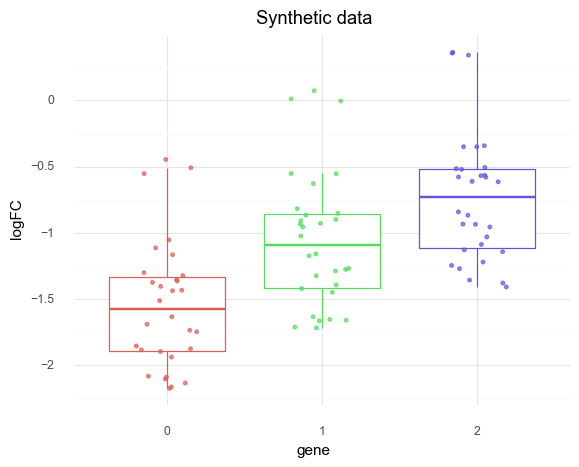

<ggplot: (8787209965265)>

In [7]:
(
    gg.ggplot(data, gg.aes(x="factor(gene)", y="logfc", color="factor(gene)"))
    + gg.geom_boxplot(outlier_color="")
    + gg.geom_jitter(width=0.2, height=0, size=1, alpha=0.7)
    + gg.scale_color_discrete(guide=False)
    + gg.labs(x="gene", y="logFC", title="Synthetic data")
)

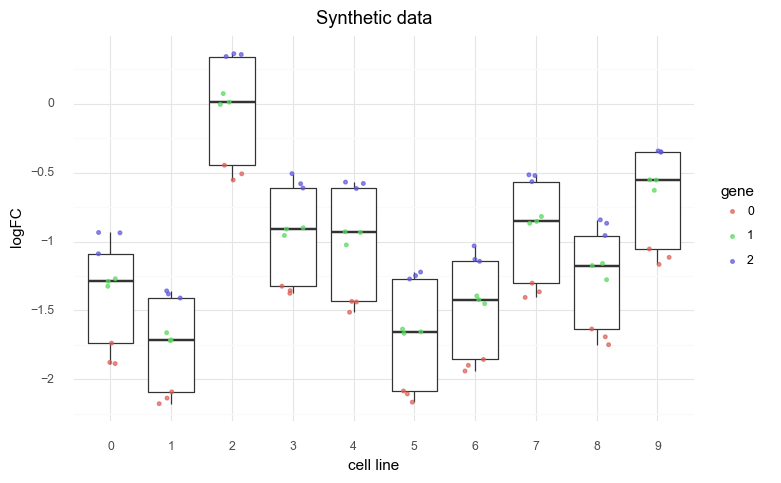

<ggplot: (8787210946017)>

In [8]:
(
    gg.ggplot(data, gg.aes(x="factor(cell_line)", y="logfc"))
    + gg.geom_boxplot(outlier_color="")
    + gg.geom_jitter(
        gg.aes(color="factor(gene)"), width=0.2, height=0, size=1, alpha=0.7
    )
    + gg.scale_color_discrete()
    + gg.theme(figure_size=(8, 5))
    + gg.labs(x="cell line", y="logFC", title="Synthetic data", color="gene")
)

In [9]:
cell_line_idx = data["cell_line"].values
gene_idx = data["gene"].values


with pm.Model() as model:
    # Hyper-priors
    mu_alpha = pm.Normal("mu_alpha", 0, 5)
    sigma_alpha = pm.Exponential("sigma_alpha", 1)
    mu_beta = pm.Normal("mu_beta", 0, 5)
    sigma_beta = pm.Exponential("sigma_beta", 1)

    # Priors
    alpha_g = pm.Normal("alpha_g", mu_alpha, sigma_alpha, shape=num_genes)
    beta_c = pm.Normal("beta_c", mu_beta, sigma_beta, shape=num_cell_lines)

    # Likelihood
    mu_gc = pm.Deterministic("mu_gc", alpha_g[gene_idx] + beta_c[cell_line_idx])
    sigma = pm.Exponential("sigma", 1)
    logfc = pm.Normal("logfc", mu_gc, sigma, observed=data["logfc"].values)

    # Sampling
    model_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    model_trace = pm.sample(4000, tune=1000, random_seed=RANDOM_SEED)
    model_post_check = pm.sample_posterior_predictive(
        model_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_c, alpha_g, sigma_beta, mu_beta, sigma_alpha, mu_alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 10000/10000 [09:17<00:00, 17.94draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
100%|██████████| 8000/8000 [00:10<00:00, 769.95it/s]


In [10]:
az_model = az.from_pymc3(
    trace=model_trace,
    model=model,
    prior=model_prior_check,
    posterior_predictive=model_post_check,
)

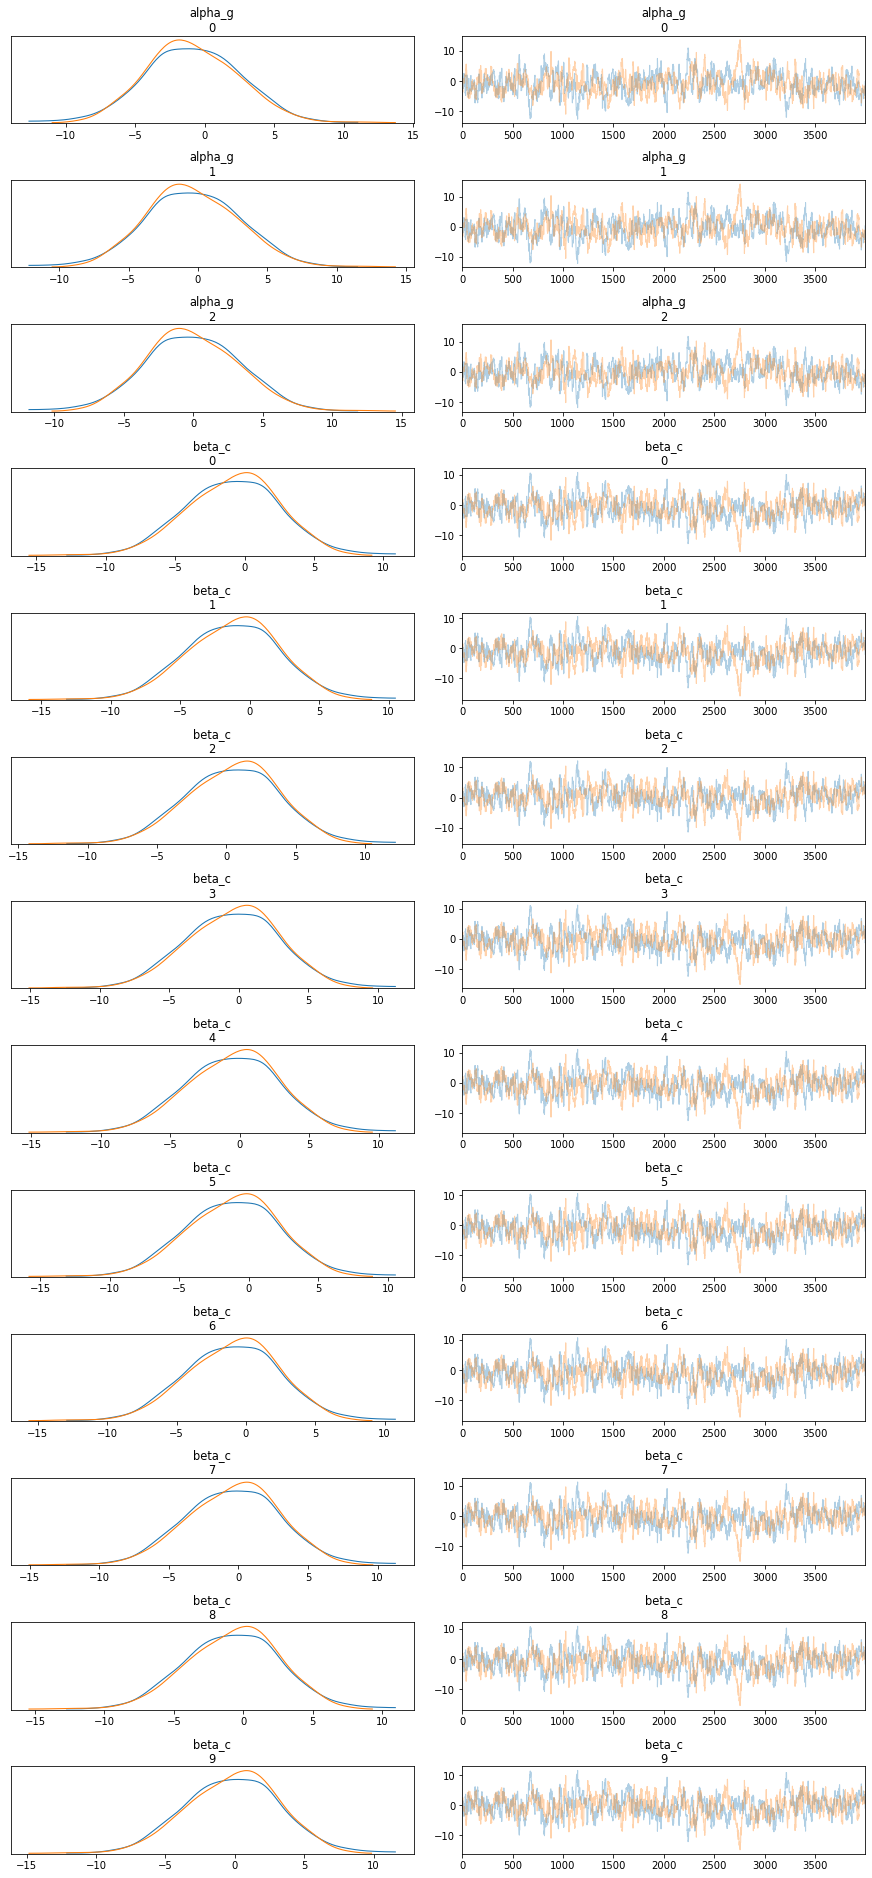

In [11]:
az.plot_trace(az_model, var_names=["alpha_g", "beta_c"])
plt.show()

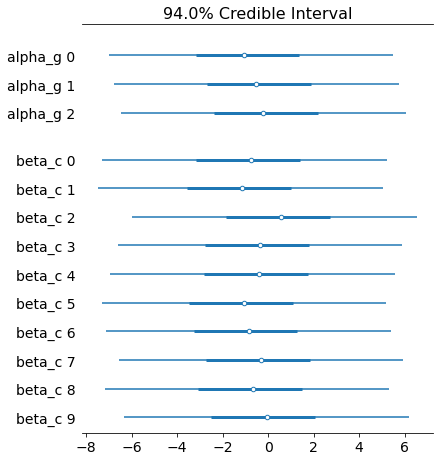

In [12]:
az.plot_forest(az_model, var_names=["alpha_g", "beta_c"], combined=True)
plt.show()

In [13]:
var_names = ["mu_alpha", "sigma_alpha", "mu_beta", "sigma_beta"]
az.summary(az_model, var_names=var_names).assign(
    real_value=[np.mean(real_params[v]) for v in var_names]
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,real_value
mu_alpha,-0.464,3.432,-6.606,5.973,0.215,0.152,254.0,254.0,255.0,474.0,1.0,-1.0
sigma_alpha,0.675,0.454,0.183,1.468,0.011,0.008,1651.0,1651.0,2043.0,2123.0,1.0,0.5
mu_beta,-0.639,3.410,-7.206,5.310,0.215,0.152,252.0,252.0,253.0,455.0,1.0,0.0
sigma_beta,0.572,0.159,0.338,0.866,0.003,0.003,2118.0,1665.0,3126.0,1714.0,1.0,0.5


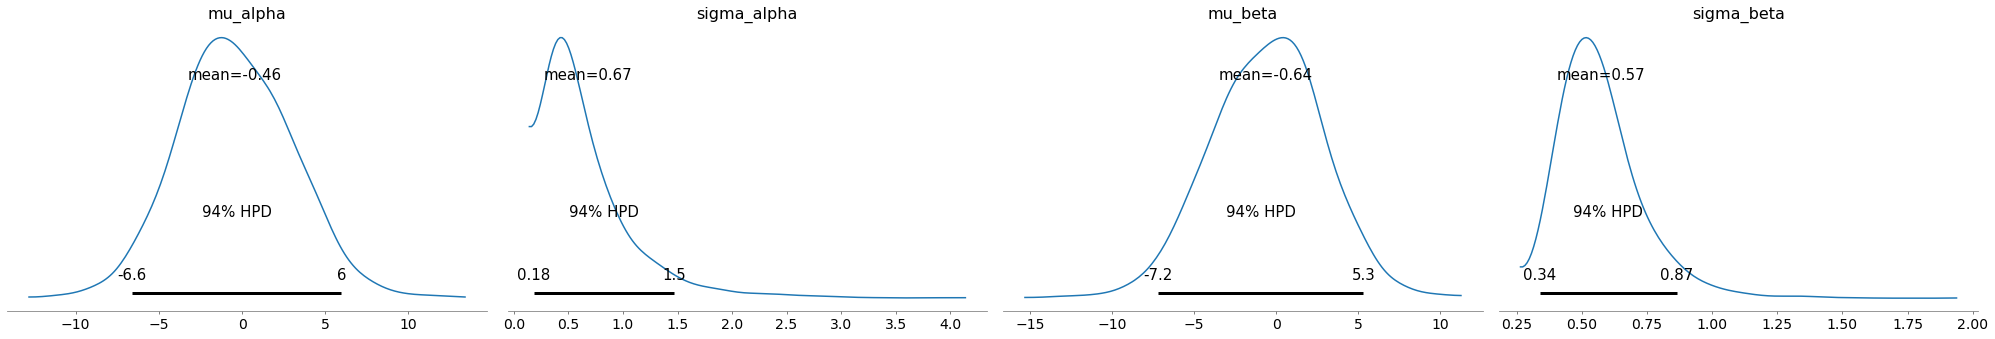

In [14]:
az.plot_posterior(az_model, var_names=var_names)
plt.show()

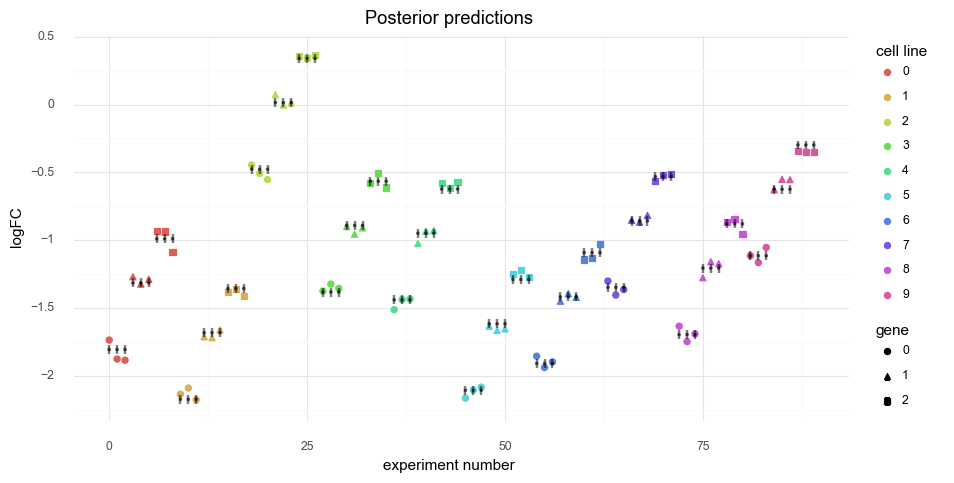

<ggplot: (8787213610861)>

In [15]:
mu_post = model_trace.get_values("mu_gc")
mu_post_mean = mu_post.mean(axis=0)
mu_post_hdi = [az.hpd(x) for x in mu_post.T]

post_data = data.copy()
post_data["mu_mean"] = mu_post_mean
post_data["mu_lower_ci"] = [x[0] for x in mu_post_hdi]
post_data["mu_upper_ci"] = [x[1] for x in mu_post_hdi]
post_data["row_i"] = list(range(len(post_data)))
(
    gg.ggplot(post_data, gg.aes(x="row_i"))
    + gg.geom_point(
        gg.aes(y="logfc", color="factor(cell_line)", shape="factor(gene)"), size=2
    )
    + gg.geom_point(gg.aes(y="mu_mean"), alpha=0.5, shape=".")
    + gg.geom_linerange(
        gg.aes(ymin="mu_lower_ci", ymax="mu_upper_ci"), alpha=0.5, size=1
    )
    + gg.theme(figure_size=(10, 5))
    + gg.labs(
        x="experiment number",
        y="logFC",
        color="cell line",
        shape="gene",
        title="Posterior predictions",
    )
)

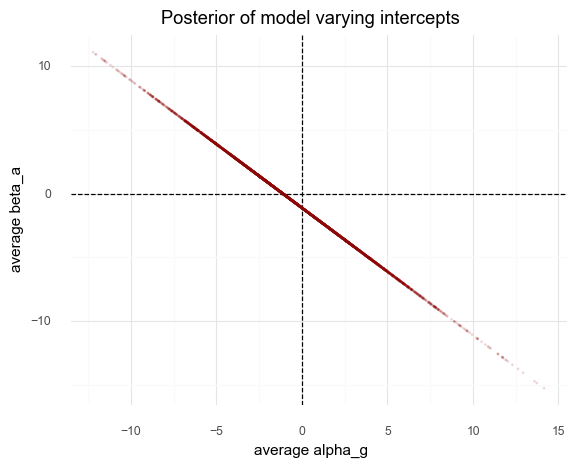

<ggplot: (8787213110793)>

In [16]:
col_names = ["gene_" + str(i) for i in range(num_genes)]
col_names += ["cell_" + str(i) for i in range(num_cell_lines)]

alpha_g_post = model_trace.get_values("alpha_g").mean(axis=1)
beta_a_post = model_trace.get_values("beta_c").mean(axis=1)

d = pd.DataFrame({"alpha_g": alpha_g_post, "beta_a": beta_a_post})
(
    gg.ggplot(d, gg.aes("alpha_g", "beta_a"))
    + gg.geom_hline(yintercept=0, linetype="--")
    + gg.geom_vline(xintercept=0, linetype="--")
    + gg.geom_point(size=0.2, alpha=0.1, color="darkred")
    + gg.labs(
        x="average alpha_g",
        y="average beta_a",
        title="Posterior of model varying intercepts",
    )
)